In [232]:
import os
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt

In [233]:
OBJ_FILENAMES = [
    ('models/', 'african_head.obj'),
    ('models/', 'body.obj'),
    ('models/', 'diablo3_pose.obj'),
    ('models/', 'test.obj'),
]
WIDTH, HEIGHT = 800, 800

OUTPUT_DIRS = [
    'project_output/step_1/',
    'project_output/step_2/',
    'project_output/step_3/',
]

LIGHT_DIR = np.array([0, 0, -1])

In [234]:
for output_dir in OUTPUT_DIRS:
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

<h1>Reading a model</h1>

In [235]:
def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return points

In [236]:
def parse_obj(filename):
    vertices = []
    faces = []
    edges = []

    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('v '):
                parts = line.split()
                vertices.append((float(parts[1]), float(parts[2]), float(parts[3])))
            elif line.startswith('f '):
                parts = line.split()
                face_vertices = [int(p.split('/')[0]) - 1 for p in parts[1:]]  # Convert 1-based indices to 0-based
                
                # Store face data
                if len(face_vertices) == 3:
                    faces.append((face_vertices[0], face_vertices[1], face_vertices[2]))
                elif len(face_vertices) > 3:  # Fan triangulation
                    for i in range(1, len(face_vertices) - 1):
                        faces.append((face_vertices[0], face_vertices[i], face_vertices[i + 1]))

                # Store edge data
                for i in range(len(face_vertices)):
                    v0 = face_vertices[i]
                    v1 = face_vertices[(i + 1) % len(face_vertices)]
                    edges.append((v0, v1))

    return vertices, edges, faces

In [237]:
def project_vertex(vertex, width, height):
    x, y, z = vertex

    x_screen = (x + 1) * 0.5 * width  # Map x from [-1, 1] to [0, width]
    y_screen = (1 - y) * 0.5 * height  # Map y from [-1, 1] to [0, height]

    return int(x_screen), int(y_screen), z


In [238]:
def render_model(vertices, edges, width, height, output_filename):
    image = Image.new('RGB', (width, height), 'white')
    pixels = image.load()

    for edge in edges:
        v0, v1 = edge
        x0, y0, _ = project_vertex(vertices[v0], width, height)
        x1, y1, _ = project_vertex(vertices[v1], width, height)
        for x, y in bresenham_line(x0, y0, x1, y1):
            if 0 <= x < width and 0 <= y < height:
                pixels[x, y] = (0, 0, 0)

    image.save(output_filename)

In [239]:
for dir, file in OBJ_FILENAMES:
    obj_path = f"{dir}{file}"
    vertices, edges, _ = parse_obj(filename=obj_path)
    out_path = f"{OUTPUT_DIRS[0]}{file.removesuffix('.obj')}.png"
    render_model(vertices, edges, WIDTH, HEIGHT, out_path)

<h1>Rendering triangles</h1>

In [240]:
def draw_filled_triangle(v0, v1, v2, image, color, z_buffer=None):
    log = False # z_buffer is not None
    if log:
        print("draw_filled_triangle:", v0, v1, v2)
    # Sort vertices by y-coordinate
    vertices = sorted([v0, v1, v2], key=lambda v: v[1])
    x0, y0, z0 = vertices[0]
    x1, y1, z1 = vertices[1]
    x2, y2, z2 = vertices[2]

    def interpolate(y, y0, x0, z0, y1, x1, z1):
        # Interpolate x and z values for the given y
        if y1 == y0:
            return x0, z0
        t = (y - y0) / (y1 - y0)
        x = x0 + t * (x1 - x0)
        z = z0 + t * (z1 - z0)
        return x, z

    def draw_scanline(y, x_start, x_end, z_start, z_end):
        if log:
            print("draw_scanline:", y, f"x: {x_start} -> {x_end}", f"z: {z_start} -> {z_end}")

        # Draw the scanline, updating the Z-buffer if needed
        xs = []
        zs = []
        updates = []
        for x in range(int(x_start), int(x_end) + 1):
            xs.append(x)
            if 0 <= x < image.width and 0 <= y < image.height:
                # Interpolate the z value for the current pixel
                z = z_start + (z_end - z_start) * (x - x_start) / (x_end - x_start) if x_end != x_start else z_start
                zs.append(z)
                if z_buffer is None:  # If no Z-buffer is provided, draw without checking depth
                    image.putpixel((x, y), color)
                else:  # If Z-buffer is provided, check the depth before drawing
                    if z > z_buffer[x, y]:
                        # print(f"Updating {x}, {y}: {z_buffer[x, y]:.6f} -> {z:.6f}")
                        updates.append((x, y, z, z_buffer[x,y]))
                        image.putpixel((x, y), color)
                        z_buffer[x, y] = z
        if log:
            print ("xs:", xs)
            print ("zs:", zs)
            print ("updates:", updates)

    # Draw upper part of the triangle
    for y in range(int(y0), int(y1) + 1):
        x_start, z_start = interpolate(y, y0, x0, z0, y2, x2, z2)
        x_end, z_end = interpolate(y, y0, x0, z0, y1, x1, z1)
        if x_start > x_end:
            x_start, x_end = x_end, x_start
            z_start, z_end = z_end, z_start
        draw_scanline(y, x_start, x_end, z_start, z_end)

    # Draw lower part of the triangle
    for y in range(int(y1) + 1, int(y2) + 1):
        x_start, z_start = interpolate(y, y1, x1, z1, y2, x2, z2)
        x_end, z_end = interpolate(y, y0, x0, z0, y2, x2, z2)
        if x_start > x_end:
            x_start, x_end = x_end, x_start
            z_start, z_end = z_end, z_start
        draw_scanline(y, x_start, x_end, z_start, z_end)
    if log:
        print()
    return z_buffer

In [241]:
for dir, file in OBJ_FILENAMES:
    obj_path = f"{dir}{file}"
    vertices, _, faces = parse_obj(obj_path)

    params =[
        (False, False, f"{OUTPUT_DIRS[1]}random/",   f"{file.removesuffix('.obj')}.png"),
        (True,  False, f"{OUTPUT_DIRS[1]}lighting/", f"{file.removesuffix('.obj')}.png"),
        (True,  True,  f"{OUTPUT_DIRS[2]}z_buffer/", f"{file.removesuffix('.obj')}.png"),
    ]

    intensities = []
    normals = []
    for use_lighting, use_z_buffer, out_dir, out_file in params:
        image = Image.new('RGB', (WIDTH, HEIGHT), 'black')
        z_buffer = np.full((HEIGHT, WIDTH), -np.inf) if use_z_buffer else None

        for face in faces:
            if use_lighting:
                # Get world-space coordinates (before projection)
                world_v0, world_v1, world_v2 = [vertices[i] for i in face]

                # Compute normal in 3D world space
                edge1 = np.subtract(world_v2, world_v0)
                edge2 = np.subtract(world_v1, world_v0)
                normal = np.cross(edge1, edge2)
                normal = normal / np.linalg.norm(normal)

                # Normalize light direction
                light_dir = LIGHT_DIR / np.linalg.norm(LIGHT_DIR)

                # Compute lighting intensity using 3D normal
                intensity = np.dot(normal, LIGHT_DIR)
                intensity = np.clip(intensity, 0, 1)

                if intensity <= 0:
                    continue # Back-face culling

                # Store intensities and normals
                intensities.append(intensity)
                normals.append(normal)

                # Convert intensity to grayscale color
                color = tuple(int(intensity * 255) for _ in range(3))
            else:
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

            # Project the 3D vertices to screen space AFTER computing lighting
            v0, v1, v2 = [project_vertex(vertices[i], WIDTH, HEIGHT) for i in face]

            # Draw filled triangle using computed lighting
            z_buffer = draw_filled_triangle(v0, v1, v2, image, color, z_buffer)

        if not os.path.exists(out_dir):
            os.makedirs(out_dir)

        image.save(f"{out_dir}{out_file}")

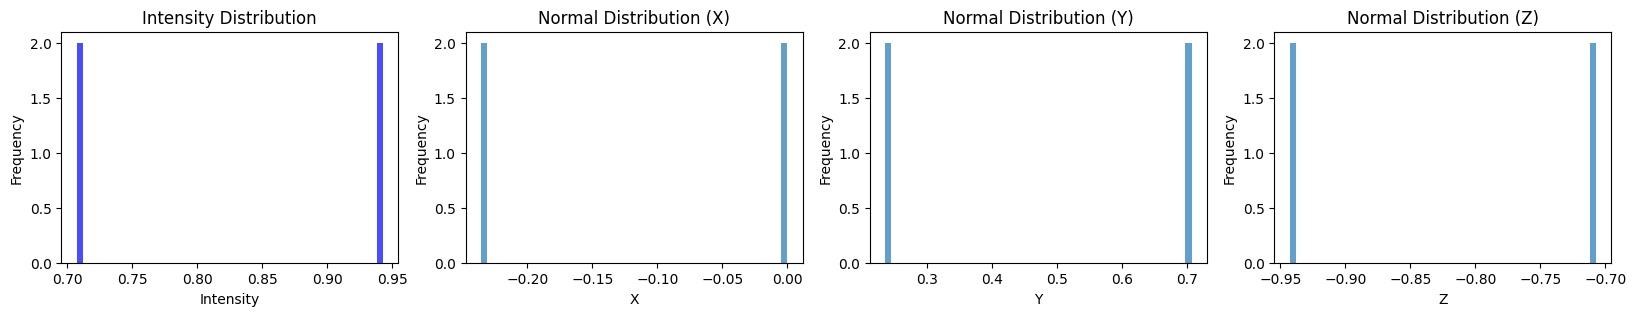

In [242]:
normals_all_stack = np.stack(normals)

# Plot Intensity Distribution
plt.figure(figsize=(20, 3))

plt.subplot(1, 4, 1)
plt.hist(intensities, bins=50, color='blue', alpha=0.7)
plt.title("Intensity Distribution")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

data = [(0, 'X'), (1, 'Y'), (2, 'Z')]

for i, coord in data:
    plt.subplot(1, 4, 2 + i)
    plt.hist(normals_all_stack[:,i], bins=50, alpha=0.7)
    plt.title(f"Normal Distribution ({coord})")
    plt.xlabel(coord)
    plt.ylabel("Frequency")

plt.show()